In [2]:
!git clone https://github.com/trinhdvt/PyTorch-DL-fundamental.git
%cd /content/PyTorch-DL-fundamental/flower-classification

fatal: destination path 'PyTorch-DL-fundamental' already exists and is not an empty directory.
/content/PyTorch-DL-fundamental/flower-classification


### Download data

In [2]:
!gdown --id 18CQK_JXSgVny-fSYFPv6qqy_lYeBfm0U
!unzip -q data_2.zip

Downloading...
From: https://drive.google.com/uc?id=18CQK_JXSgVny-fSYFPv6qqy_lYeBfm0U
To: /content/PyTorch-DL-fundamental/flower-classification/data_2.zip
100% 238M/238M [00:01<00:00, 163MB/s]


## Import library

In [4]:
import torch
import matplotlib.pyplot as plt

from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from core import build_model, data_loader, train_helper


from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)
%matplotlib inline

### Load data with PyTorch

In [5]:
train_dir = "./data_2/train/"
val_dir = "./data_2/valid/"
test_dir = "./data_2/test/"
batch_size = 32

class_names, train_loader, test_loader, val_loader  = data_loader.load_data(train_dir, 
                                                    test_dir, 
                                                    val_dir, 
                                                    batch_size=batch_size,
                                                    pin_memory=True)

print("Class: ", class_names)
print(f"Train set: {len(train_loader) * batch_size} images")
print(f"Validation set: {len(val_loader) * batch_size} images")
print(f"Test set: {len(test_loader) * batch_size} images")

Class:  ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Train set: 3328 images
Validation set: 384 images
Test set: 672 images


### Visualize First Train Batch

In [ ]:
for images, labels in train_loader:
    data_loader.batch_visualize(images, labels, class_names)
    break


### Define CNN Model

In [6]:
summary(build_model.CNN(num_classes=5), (3, 224, 224), batch_size=1, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 16, 224, 224]             448
              ReLU-2          [1, 16, 224, 224]               0
         ConvBlock-3          [1, 16, 224, 224]               0
         MaxPool2d-4          [1, 16, 112, 112]               0
            Conv2d-5          [1, 32, 112, 112]          12,832
              ReLU-6          [1, 32, 112, 112]               0
         ConvBlock-7          [1, 32, 112, 112]               0
         MaxPool2d-8            [1, 32, 56, 56]               0
            Conv2d-9            [1, 64, 56, 56]          51,264
             ReLU-10            [1, 64, 56, 56]               0
        ConvBlock-11            [1, 64, 56, 56]               0
        MaxPool2d-12            [1, 64, 28, 28]               0
           Conv2d-13           [1, 128, 28, 28]          73,856
             ReLU-14           [1, 128,

### Train model

In [7]:
model = build_model.CNN(num_classes=len(class_names), input_size=224, in_channels=3).to(params['device'])

params = {
    "batch_size": 32,
    "num_workers": 0,
    "epochs":5,
    "lr": 0.001,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}
params.update({
    "loss_fn": torch.nn.NLLLoss(),
    "optimzer": torch.optim.Adam(model.parameters(), lr=params['lr'])
})

# init tensorboard
tb = SummaryWriter()
images, labels = next(iter(train_loader))
grid = make_grid(data_loader.inv_normalize(images))
tb.add_image("images", grid)
tb.add_graph(model, images)
tb.close()

In [8]:
train_hist = train_helper.traning_loops(epochs=params['epochs'],
                                        model=model,
                                        train_loader=train_loader,
                                        val_loader=val_loader,
                                        optimizer=params['optimzer'],
                                        criterion=params['loss_fn'],
                                        device=params['device'],
                                        blocking=True)

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

### Visualize Training results

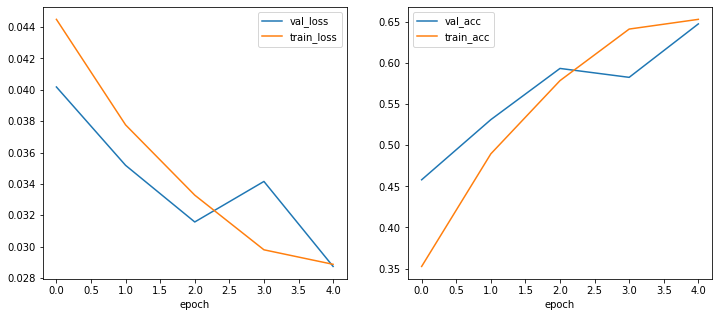

In [9]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flat
metrics_name = (("val_loss", "train_loss"),("val_acc", "train_acc"))

for i, ax in enumerate(axes):
    metric = metrics_name[i]
    ax.plot(train_hist[metric[0]], label=metric[0])
    ax.plot(train_hist[metric[1]], label=metric[1])
    ax.set_xlabel("epoch")
    ax.legend()

plt.show()

### Measuring Accuracy

In [11]:
train_helper.test_model(model, 
                        test_loader=test_loader, 
                        device=params['device'],
                        blocking=True)

  0%|          | 0/21 [00:00<?, ?it/s]

Accuracy: 0.6949152542372882


### Save model

In [12]:
torch.save(model.state_dict(), "last_model.pth")

Labels: [4 2 3 0 1 4 0 0 4 4 4 2 1 3 4 4 2 0 0 1 1 1 1 2 0 0 0 4 4 0 3 1]
Class:  tulip rose sunflower daisy dandelion tulip daisy daisy tulip tulip tulip rose dandelion sunflower tulip tulip rose daisy daisy dandelion dandelion dandelion dandelion rose daisy daisy daisy tulip tulip daisy sunflower dandelion


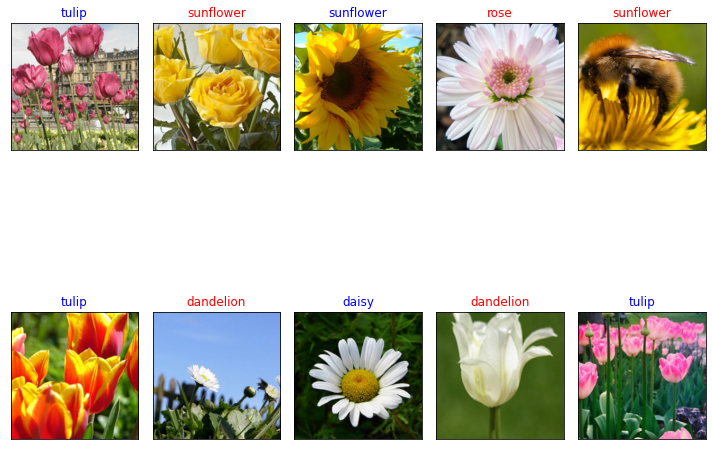

In [13]:
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        # to device
        imgs = imgs.to(params['device'])
        labels = labels.to(params['device'])
        
        # get the output
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)

        # plot results
        data_loader.batch_visualize(images=imgs,
                                    truth_labels=labels,
                                    class_names=class_names,
                                    predicted=predicted,
                                    figsize=(10, 10))
        break